In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Đang dùng:", device)

Đang dùng: cuda


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),  # tầng ẩn 1
            nn.ReLU(),
            nn.Linear(128, 64),     # tầng ẩn 2
            nn.ReLU(),
            nn.Linear(64, 10)       # tầng đầu ra
        )

    def forward(self, x):
        x = self.flatten(x)         # 1x28x28 → 784
        logits = self.linear_relu_stack(x)
        return logits


In [18]:
model = NeuralNetwork().to(device)
model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6], device='cuda:0')


In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

In [10]:
loss_fn = nn.CrossEntropyLoss()         # Dùng cho phân loại nhiều lớp
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss / len(dataloader) # Trả về loss trung bình cho epoch            


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            batch_loss = loss_fn(pred, y).item() # Lấy loss của batch
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss # Trả về loss trung bình    

In [12]:
epochs = 5
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_test_loss = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
print("Done!")
print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of test_losses: {len(test_losses)}")

Epoch 1
-------------------------------
loss: 2.306474  [   64/60000]
loss: 2.153396  [ 6464/60000]
loss: 1.812999  [12864/60000]
loss: 1.389937  [19264/60000]
loss: 1.173777  [25664/60000]
loss: 1.207698  [32064/60000]
loss: 0.964063  [38464/60000]
loss: 0.906278  [44864/60000]
loss: 0.912473  [51264/60000]
loss: 0.780493  [57664/60000]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.807647 

Epoch 2
-------------------------------
loss: 0.867441  [   64/60000]
loss: 0.692127  [ 6464/60000]
loss: 0.603633  [12864/60000]
loss: 0.673751  [19264/60000]
loss: 0.707412  [25664/60000]
loss: 0.508514  [32064/60000]
loss: 0.799097  [38464/60000]
loss: 0.746185  [44864/60000]
loss: 0.665215  [51264/60000]
loss: 0.557196  [57664/60000]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.637432 

Epoch 3
-------------------------------
loss: 0.677743  [   64/60000]
loss: 0.531658  [ 6464/60000]
loss: 0.535939  [12864/60000]
loss: 0.508218  [19264/60000]
loss: 0.450367  [25664/60000]
loss: 0.771092  [32064/600

In [13]:
import torch
import torchvision.models as models

In [14]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

In [15]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

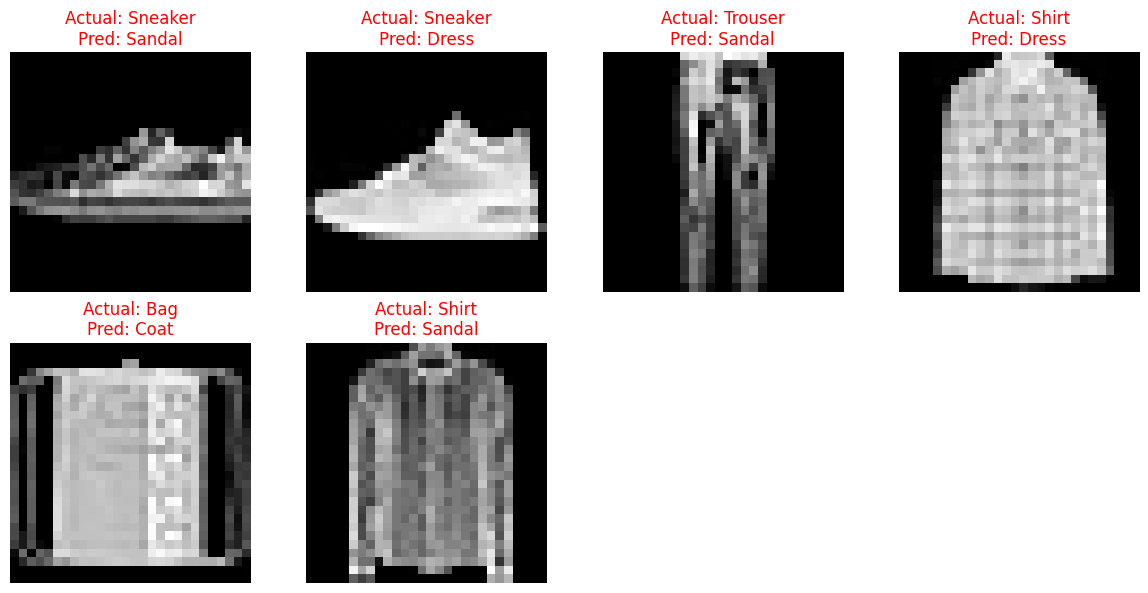

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa tên các lớp FashionMNIST (có thể đặt ở đầu file cùng với các import khác)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Lấy một batch dữ liệu từ test_dataloader
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Chuyển hình ảnh và nhãn đến device (nếu mô hình đang ở trên GPU)
images = images.to(device)
labels = labels.to(device)

# Đưa model về chế độ đánh giá
model.eval()
with torch.no_grad(): # Không tính gradient trong quá trình đánh giá
    outputs = model(images)

# Lấy dự đoán
_, predicted = torch.max(outputs.data, 1)

# Hiển thị một vài hình ảnh
num_images_to_show = 6 # Bạn có thể thay đổi số lượng hình ảnh muốn hiển thị
plt.figure(figsize=(12, 6))
for i in range(num_images_to_show):
    ax = plt.subplot(2, num_images_to_show // 2 + 1, i + 1)
    # Chuyển tensor về CPU, loại bỏ chiều kênh (nếu có), và chuyển sang numpy để hiển thị
    img = images[i].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Actual: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}",
                 color=("green" if predicted[i] == labels[i] else "red"))
    ax.axis('off')
plt.tight_layout()
plt.show()

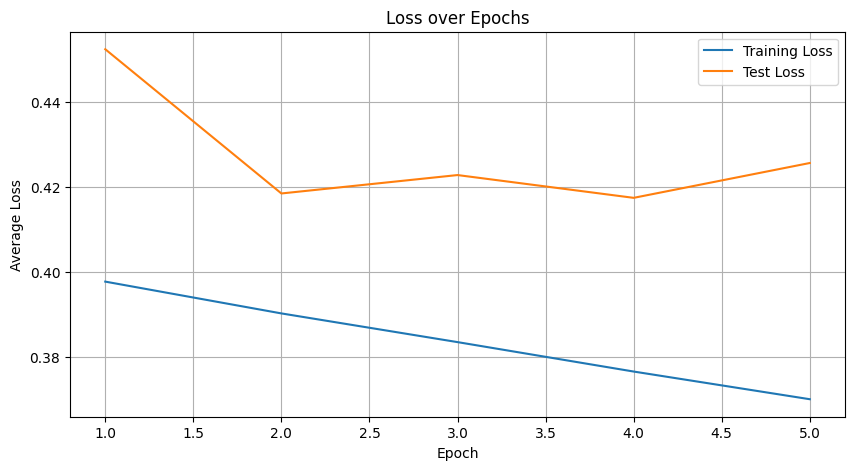

In [ ]:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True)
    plt.show()